In [2]:
import numpy as np
import pandas as pd
import gzip
import json

from pprint import pprint
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import StratifiedKFold
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
# 1) Imports

import re
import torch
import numpy as np
import pandas as pd
import json
import gzip

from transformers import AutoTokenizer, AutoModel, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.utils.class_weight import compute_class_weight

from datasets import Dataset, DatasetDict

import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import lightgbm as lgb
import optuna
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import lightgbm as lgb
import optuna
from sklearn.metrics import accuracy_score, classification_report
import joblib

nltk.download('stopwords')
turkish_stopwords = stopwords.words('turkish')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ilgazsahin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
##### 1) Read train_classification.csv more carefully
train_classification_df = pd.read_csv("train-classification.csv")

# If "Unnamed: 0" is your user_id (and there's no user_id column yet), rename it
if "Unnamed: 0" in train_classification_df.columns and "user_id" not in train_classification_df.columns:
    train_classification_df.rename(columns={"Unnamed: 0": "user_id"}, inplace=True)

# Rename "label" to "category"
train_classification_df.rename(columns={"label": "category"}, inplace=True)

# 2) Read & unify the 3 annotation files in a loop
annotation_files = [
    "annotated_users_CS412-70f170887437.csv",
    "annotated_users_CS412-1210cecaf90d.csv",
    "annotated_users_CS412-2fa73b22df12.csv",
]

all_annotated = []
for ann_file in annotation_files:
    df_temp = pd.read_csv(ann_file)

    # Rename "Unnamed: 0" to "user_id" if needed
    if "Unnamed: 0" in df_temp.columns and "user_id" not in df_temp.columns:
        df_temp.rename(columns={"Unnamed: 0": "user_id"}, inplace=True)

    # Rename influencerCategory to category
    if "influencerCategory" in df_temp.columns:
        df_temp.rename(columns={"influencerCategory": "category"}, inplace=True)

    # Drop rows missing a category
    df_temp.dropna(subset=["category"], inplace=True)

    # Lowercase the category
    df_temp["category"] = df_temp["category"].str.lower()

    # Drop any unwanted columns that might exist
    for col in ["url", "influencerMention", "accountType"]:
        if col in df_temp.columns:
            df_temp.drop(columns=col, inplace=True)

    df_temp.reset_index(drop=True, inplace=True)
    all_annotated.append(df_temp)

annotated_users_df = pd.concat(all_annotated, ignore_index=True)

# 3) Combine with your train_classification_df
train_classification_df = pd.concat([train_classification_df, annotated_users_df],
                                    ignore_index=True)

# 4) Unify labels (make sure everything is lowercase, etc.)
train_classification_df["category"] = train_classification_df["category"].str.lower()

# 5) Remove duplicate user_ids if they appear multiple times
#    keep="last" keeps the final row of any duplicates
train_classification_df.drop_duplicates(subset="user_id", keep="last", inplace=True)
train_classification_df.reset_index(drop=True, inplace=True)

# 6) Create your mapping of user_id → category
username2_category = train_classification_df.set_index("user_id")["category"].to_dict()

In [4]:
train_data_path = "training-dataset.jsonl.gz"

username2posts_train = dict()
username2profile_train = dict()

username2posts_test = dict()
username2profile_test = dict()


with gzip.open(train_data_path, "rt") as fh:
  for line in fh:
    sample = json.loads(line)

    profile = sample["profile"]
    username = profile["username"]
    if username in username2_category:
      # train data info
      username2posts_train[username] = sample["posts"]
      username2profile_train[username] = profile


    else:
      # it is test data info
      username2posts_test[username] = sample["posts"]
      username2profile_test[username] = profile

In [5]:
# Profile Dataframe
train_profile_df = pd.DataFrame(username2profile_train).T.reset_index(drop=True)
test_profile_df = pd.DataFrame(username2profile_test).T.reset_index(drop=True)

In [6]:
# profile: category_name biography entities business_category_name category_enum username full_name
# posts: captions

In [7]:
# 2) Preprocessing & Corpus-Building Functions

def preprocess_text(text: str):
    """
    Basic preprocessing for Turkish text:
    - Lower casing with .casefold()
    - Removing URLs
    - Removing special characters (optional: keep emojis if desired)
    - Removing digits
    - Stripping extra whitespace
    """
    # Lower-case (casefold is a more aggressive form of lower)
    text = text.casefold()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove special characters except basic Turkish letters, numbers, hashtags, @
    text = re.sub(r'[^a-zçğıöşü\s#@]', '', text)
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text
    
def build_corpus(username2posts, username2profile, include_all_features=True):
    """
    1. Loops over each username in username2posts
    2. Cleans each post caption using preprocess_text
    3. Optionally, appends user profile info (biography, category_name, etc.)
    4. Returns (corpus, usernames) for further processing
    """
    corpus = []
    usernames = []

    for username, posts in username2posts.items():
        usernames.append(username)

        # Collect and clean posts
        cleaned_captions = []
        for post in posts:
            post_caption = post.get("caption", "")
            if post_caption is None:
                continue
            post_caption = preprocess_text(post_caption)
            if post_caption:
                cleaned_captions.append(post_caption)

        # Optionally include profile features
        if include_all_features:
            profile = username2profile.get(username, {})
            feature_texts = []

            profile_fields = [
                "biography",
                "category_name",
                "entities",
                "business_category_name",
                "category_enum",
                "full_name"
            ]
            for field in profile_fields:
                value = profile.get(field, "")
                if value:
                    # Convert list/dict to string if needed
                    if isinstance(value, (dict, list)):
                        value = str(value)
                    value = preprocess_text(value)
                    if value:
                        feature_texts.append(value)

            # Combine all profile features and append
            if feature_texts:
                features_combined = " ".join(feature_texts)
                cleaned_captions.append(features_combined)

        # Combine everything into a single text for this user
        user_text = "\n".join(cleaned_captions)
        corpus.append(user_text)

    return corpus, usernames

# 3) Build the Train/Test Corpora

corpus_train, train_usernames = build_corpus(
    username2posts_train,    # Replace with your actual variable
    username2profile_train,  # Replace with your actual variable
    include_all_features=True
)
corpus_test, test_usernames = build_corpus(
    username2posts_test,     # Replace with your actual variable
    username2profile_test,   # Replace with your actual variable
    include_all_features=True
)

# Retrieve the labels for training (we assume test data is unlabeled or 'NA')
y_train = [username2_category.get(uname, "NA") for uname in train_usernames]  # Replace with your actual variable
assert y_train.count("NA") == 0, "Some training samples have 'NA' as category."

# 4) Train-Validation Split

x_train_texts, x_val_texts, y_train_labels, y_val_labels = train_test_split(
    corpus_train,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

print(f"Training texts: {len(x_train_texts)}")
print(f"Validation texts: {len(x_val_texts)}")

# 5) Label Encoding

#label_encoder = LabelEncoder()
#y_train_encoded = label_encoder.fit_transform(y_train_labels)
#y_val_encoded = label_encoder.transform(y_val_labels)

# === Begin Class Merging ===

# Merge 'gaming' into 'tech' in training and validation labels
y_train_labels = ['tech' if label == 'gaming' else label for label in y_train_labels]
y_val_labels = ['tech' if label == 'gaming' else label for label in y_val_labels]

# Re-encode labels after merging
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_labels)
y_val_encoded = label_encoder.transform(y_val_labels)

print("Classes:", label_encoder.classes_)

# Recompute class weights after merging
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Updated Class weights after merging 'gaming' into 'tech':", class_weight_dict)

# Update training and validation DataFrames
train_df = pd.DataFrame({
    'text': x_train_texts,
    'label': y_train_encoded
})

val_df = pd.DataFrame({
    'text': x_val_texts,
    'label': y_val_encoded
})

# === End Class Merging ===

# 6) Create Hugging Face Datasets

# Create a pandas DataFrame for training
train_df = pd.DataFrame({
    'text': x_train_texts,
    'label': y_train_encoded
})

# Create a pandas DataFrame for validation
val_df = pd.DataFrame({
    'text': x_val_texts,
    'label': y_val_encoded
})

# Convert pandas DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Combine into a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})

print(dataset)

# 7) Tokenization

model_name = "dbmdz/bert-base-turkish-uncased"  # or any Turkish BERT variant
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Rename 'label' to 'labels' as expected by the model
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

print(tokenized_datasets)

# 8) Compute Class Weights

# Recompute Class Weights with Updated Labels
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Recomputed Class weights after merging:", class_weight_dict)

# 9) Define Evaluation Metrics

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted', zero_division=0)
    acc = accuracy_score(p.label_ids, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# 10) Define the Model

num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

# 11) Define Training Arguments

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    report_to='none'
)

# 12) Define a Custom Trainer to Include Class Weights

class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        # Convert class weights to float tensor and move to the model's device
        weight = torch.tensor(list(self.class_weights.values()), dtype=torch.float).to(model.device)
        loss_fct = nn.CrossEntropyLoss(weight=weight)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# 13) Initialize the Custom Trainer

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    class_weights=class_weight_dict
)


Training texts: 2263
Validation texts: 566
Classes: ['art' 'entertainment' 'fashion' 'food' 'health and lifestyle'
 'mom and children' 'sports' 'tech' 'travel']
Updated Class weights after merging 'gaming' into 'tech': {0: 1.6118233618233617, 1: 0.9488469601677149, 2: 1.0347508001828989, 3: 0.6001060726597719, 4: 0.5958399157451291, 5: 2.167624521072797, 6: 2.4651416122004357, 7: 0.8381481481481482, 8: 1.0476851851851852}
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2263
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 566
    })
})


Map:   0%|          | 0/2263 [00:00<?, ? examples/s]

Map:   0%|          | 0/566 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2263
    })
    validation: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 566
    })
})
Recomputed Class weights after merging: {0: 1.6118233618233617, 1: 0.9488469601677149, 2: 1.0347508001828989, 3: 0.6001060726597719, 4: 0.5958399157451291, 5: 2.167624521072797, 6: 2.4651416122004357, 7: 0.8381481481481482, 8: 1.0476851851851852}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [8]:
# Assuming y_train_labels contains the original string labels
class_distribution = pd.Series(y_train_labels).value_counts()
print(class_distribution)


health and lifestyle    422
food                    419
tech                    300
entertainment           265
fashion                 243
travel                  240
art                     156
mom and children        116
sports                  102
Name: count, dtype: int64


In [9]:
# 14) Train the Model

trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.228600,1.206192,0.632509,0.627148,0.632509,0.618602
2,1.231800,1.182279,0.639576,0.641241,0.639576,0.634365
3,0.825800,1.291686,0.653710,0.644196,0.653710,0.646434


TrainOutput(global_step=1698, training_loss=1.2047921902158938, metrics={'train_runtime': 2611.6621, 'train_samples_per_second': 2.599, 'train_steps_per_second': 0.65, 'total_flos': 446593305413376.0, 'train_loss': 1.2047921902158938, 'epoch': 3.0})

In [10]:
# 15) Evaluate the Model

eval_results = trainer.evaluate()

print("\n--- Evaluation Results ---")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")

# Detailed Classification Report

predictions, labels, _ = trainer.predict(tokenized_datasets['validation'])
preds = np.argmax(predictions, axis=1)

print("\n--- Detailed Classification Report ---")
print(classification_report(labels, preds, target_names=label_encoder.classes_, zero_division=0))



--- Evaluation Results ---
eval_loss: 1.2917
eval_accuracy: 0.6537
eval_precision: 0.6442
eval_recall: 0.6537
eval_f1: 0.6464
eval_runtime: 26.3180
eval_samples_per_second: 21.5060
eval_steps_per_second: 5.3960
epoch: 3.0000

--- Detailed Classification Report ---
                      precision    recall  f1-score   support

                 art       0.39      0.23      0.29        39
       entertainment       0.48      0.48      0.48        66
             fashion       0.70      0.72      0.71        61
                food       0.81      0.88      0.84       105
health and lifestyle       0.63      0.62      0.63       106
    mom and children       0.46      0.41      0.44        29
              sports       0.55      0.72      0.62        25
                tech       0.70      0.67      0.68        75
              travel       0.72      0.78      0.75        60

            accuracy                           0.65       566
           macro avg       0.60      0.61      0.6

In [11]:
# Save the model to a directory
trainer.save_model("fine_tuned_bert_model")


In [12]:
# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-uncased')
model = BertModel.from_pretrained('dbmdz/bert-base-turkish-uncased')
model.eval()  # Set model to evaluation mode

# Function to extract [CLS] embeddings
def extract_cls_embeddings(texts, batch_size=32):
    embeddings = []
    dataloader = DataLoader(texts, batch_size=batch_size)

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting BERT Embeddings"):
            encoded_input = tokenizer(batch, padding=True, truncation=True, return_tensors='pt', max_length=128)
            input_ids = encoded_input['input_ids']
            attention_mask = encoded_input['attention_mask']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] token embeddings
            embeddings.append(cls_embeddings.cpu().numpy())

    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings

# Extract embeddings for training and validation sets
x_train_embeddings = extract_cls_embeddings(x_train_texts)
x_val_embeddings = extract_cls_embeddings(x_val_texts)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Extracting BERT Embeddings: 100%|███████████████| 18/18 [00:50<00:00,  2.79s/it]


In [13]:
# Define Alignment Function

def align_embeddings_labels(usernames, embeddings, label_mapping):
    """
    Aligns embeddings with their corresponding labels based on usernames.

    Parameters:
    - usernames (list): List of usernames corresponding to embeddings.
    - embeddings (np.ndarray): Array of embeddings.
    - label_mapping (dict): Mapping from username to category.

    Returns:
    - filtered_embeddings (np.ndarray): Aligned embeddings.
    - filtered_usernames (list): Corresponding usernames.
    - filtered_labels (list): Corresponding labels.
    """
    usernames_array = np.array(usernames)
    valid_usernames = set(label_mapping.keys())

    # Create a boolean mask
    valid_mask = np.isin(usernames_array, list(valid_usernames))

    # Filter embeddings and usernames
    filtered_embeddings = embeddings[valid_mask]
    filtered_usernames = usernames_array[valid_mask].tolist()

    # Create labels
    filtered_labels = [label_mapping[u] for u in filtered_usernames]

    # Final verification
    assert filtered_embeddings.shape[0] == len(filtered_labels), "Mismatch between embeddings and labels!"

    return filtered_embeddings, filtered_usernames, filtered_labels

In [14]:

# Initialize the scaler
scaler = StandardScaler()

# Fit on training embeddings and transform both training and validation embeddings
x_train_scaled = scaler.fit_transform(x_train_embeddings)
x_val_scaled = scaler.transform(x_val_embeddings)

print("Training embeddings scaled.")

Training embeddings scaled.


In [15]:
# Initialize PCA - adjust n_components based on your dataset
pca = PCA(n_components=100, random_state=42)  # You can choose the number of components based on explained variance

# Fit PCA on training data and transform both training and validation data
x_train_pca = pca.fit_transform(x_train_scaled)
x_val_pca = pca.transform(x_val_scaled)

print(f"PCA completed. Number of components: {pca.n_components_}")


PCA completed. Number of components: 100


In [16]:
# Prepare LightGBM datasets
train_data = lgb.Dataset(x_train_pca, label=y_train_encoded)
val_data = lgb.Dataset(x_val_pca, label=y_val_encoded, reference=train_data)


In [17]:
pip install dask[dataframe]

zsh:1: no matches found: dask[dataframe]
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [30]:
# Compute Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Define Optuna Objective with PCA-Transformed Data and Class Weights
def objective_with_weights_pca(trial):
    param = {
        'objective': 'multiclass',
        'num_class': len(np.unique(y_train_encoded)),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10, log=True),
        'random_state': 42,
        'class_weight': class_weight_dict  # Apply class weights
    }

    # Use PCA-transformed training data
    model_lgbm = lgb.LGBMClassifier(**param)
    model_lgbm.fit(x_train_pca, y_train_encoded)

    # Validate on PCA-transformed validation data
    val_preds = model_lgbm.predict(x_val_pca)
    val_accuracy = accuracy_score(y_val_encoded, val_preds)
    return val_accuracy

# Run Optuna Study with PCA-Transformed Data
study_weights = optuna.create_study(direction='maximize')
study_weights.optimize(objective_with_weights_pca, n_trials=50)

# Retrieve Best Parameters
best_params_weights = study_weights.best_params
best_params_weights['class_weight'] = class_weight_dict  # Add class weights

print("\nBest parameters with class weights:", best_params_weights)
print("Best cross-validation accuracy with class weights:", study_weights.best_value)

# Train Final Model with Best Parameters
final_model_weights = lgb.LGBMClassifier(**best_params_weights, random_state=42)
final_model_weights.fit(x_train_pca, y_train_encoded)  # Use PCA-transformed training data

# Evaluate on Validation Set
y_val_pred_weights = final_model_weights.predict(x_val_pca)  # Use PCA-transformed validation data
print("\n--- Validation Data Results with PCA and Class Weights ---")
print("Accuracy:", accuracy_score(y_val_encoded, y_val_pred_weights))
print("Classification Report:")
print(classification_report(y_val_encoded, y_val_pred_weights, target_names=label_encoder.classes_, zero_division=0))


[I 2025-01-05 20:35:28,663] A new study created in memory with name: no-name-f12f8a8d-2384-47f0-b86e-631de620544a
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-05 20:35:32,698] Trial 0 finished with value: 0.5512367491166078 and parameters: {'learning_rate': 0.09900321114564728, 'num_leaves': 79, 'max_depth': 14, 'n_estimators': 633, 'subsample': 0.7149735379502773, 'colsample_bytree': 0.6622519541490444, 'reg_lambda': 0.00040150084811293584, 'reg_alpha': 0.004463504385931918}. Best is trial 0 with value: 0.5512367491166078.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits wit

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-05 20:35:34,223] Trial 1 finished with value: 0.5565371024734982 and parameters: {'learning_rate': 0.11861841884373789, 'num_leaves': 83, 'max_depth': 47, 'n_estimators': 438, 'subsample': 0.6733070247645685, 'colsample_bytree': 0.6332383170675125, 'reg_lambda': 0.0005919792513124356, 'reg_alpha': 4.217043756041413}. Best is trial 1 with value: 0.5565371024734982.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-05 20:36:02,936] Trial 2 finished with value: 0.558303886925795 and parameters: {'learning_rate': 0.02628454426166896, 'num_leaves': 86, 'max_depth': 9, 'n_estimators': 885, 'subsample': 0.8856532230744125, 'colsample_bytree': 0.7662120075783518, 'reg_lambda': 0.9588796414884325, 'reg_alpha': 0.002571721873872343}. Best is trial 2 with value: 0.558303886925795.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Best parameters with class weights: {'learning_rate': 0.02628454426166896, 'num_leaves': 86, 'max_depth': 9, 'n_estimators': 885, 'subsample': 0.8856532230744125, 'colsample_bytree': 0.7662120075783518, 'reg_lambda': 0.9588796414884325, 'reg_alpha': 0.002571721873872343, 'class_weight': {0: 1.6118233618233617, 1: 0.9488469601677149, 2: 1.0347508001828989, 3: 0.6001060726597719, 4: 0.5958399157451291, 5: 2.167624521072797, 6: 2.4651416122004357, 7: 0.8381481481481482, 8: 1.0476851851851852}}
Best cross-validation accuracy with class weights: 0.558303886925795
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training fro

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [23]:
from joblib import dump

# Save BERT model and tokenizer
model.save_pretrained("bert_model")
tokenizer.save_pretrained("bert_model")
print("BERT model and tokenizer saved successfully.")

# Save LightGBM model
final_model_weights.booster_.save_model("lightgbm_model.txt")
print("LightGBM model saved successfully.")

# Save scaler, PCA, and label encoder
dump(scaler, "scaler.joblib")
dump(pca, "pca.joblib")
dump(label_encoder, "label_encoder.joblib")
print("Preprocessing objects saved successfully.")



BERT model and tokenizer saved successfully.
LightGBM model saved successfully.
Preprocessing objects saved successfully.


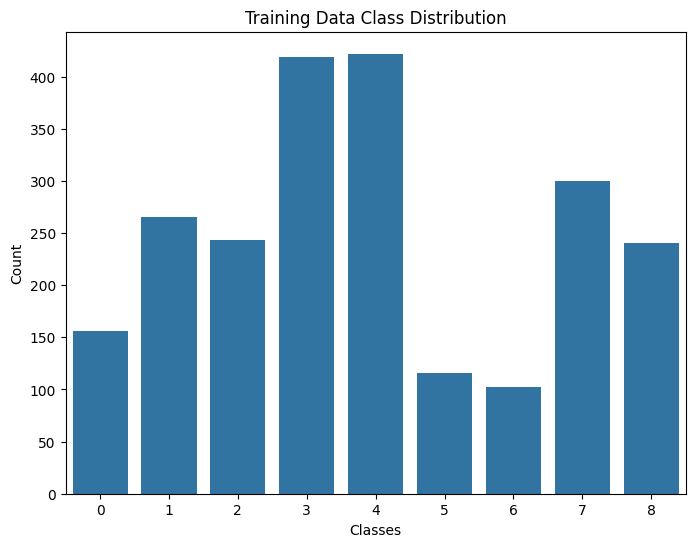

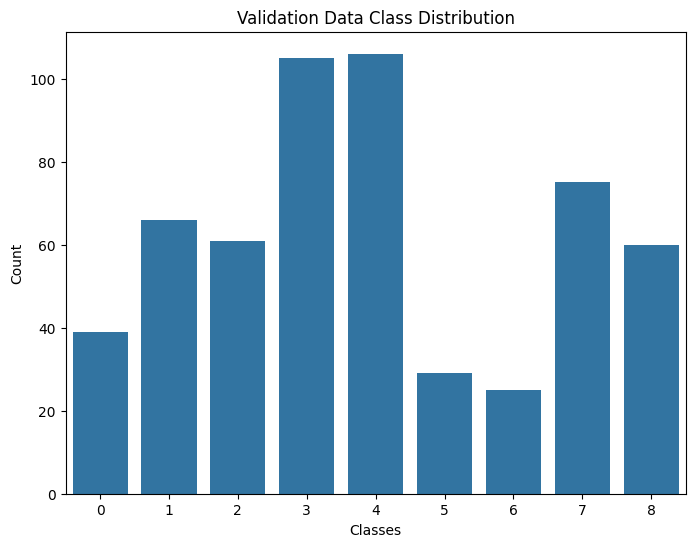

In [25]:
# Training data class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_encoded)
plt.title('Training Data Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

# Validation data class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y_val_encoded)
plt.title('Validation Data Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()


In [34]:
# Step 1: Load usernames from test-classification-round2.dat
with open("test-classification-round2.dat", "r", encoding="utf-8") as file:
    usernames = file.read().strip().split("\n")

# Step 2: Simulate username-to-post and username-to-profile mappings
# Modify to include structured data for posts and profiles
username2posts_test = {username: [{"caption": f"Sample post caption for {username}"}] for username in usernames}
username2profile_test = {username: {"bio": f"Sample bio for {username}"} for username in usernames}

# Step 3: Build corpus for test set
corpus_test, test_usernames = build_corpus(
    username2posts_test, 
    username2profile_test, 
    include_all_features=True
)
x_test_texts = corpus_test

# Step 4: Extract BERT embeddings
x_test_embeddings = extract_cls_embeddings(x_test_texts)

# Step 5: Scale the embeddings (Use the scaler fitted on training data)
x_test_scaled = scaler.transform(x_test_embeddings)

# Step 6: Transform using PCA (Use the PCA fitted on training data)
x_test_pca = pca.transform(x_test_scaled)
print(f"Test data transformed using PCA. Shape: {x_test_pca.shape}")

# Step 7: Predict using the final trained LightGBM model
test_preds = final_model_weights.predict_proba(x_test_pca)  # Use predict_proba for probabilities
test_pred_classes = np.argmax(test_preds, axis=1)  # Get class predictions
decoded_preds = label_encoder.inverse_transform(test_pred_classes)  # Decode to original labels

# Define the format_category function
def format_category(category):
    """
    Formats the category by capitalizing each word except "and".
    """
    words = category.split()
    formatted_words = [word.capitalize() if word.lower() != "and" else word for word in words]
    return " ".join(formatted_words)

# Step 8: Format and save predictions
output = {uname: format_category(decoded_preds[i]) for i, uname in enumerate(test_usernames)}
with open("task1_round2.json", "w", encoding='utf-8') as of:
    json.dump(output, of, indent=4, ensure_ascii=False)

print("Predictions saved to output.json successfully.")


Extracting BERT Embeddings: 100%|███████████████| 32/32 [00:09<00:00,  3.25it/s]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Test data transformed using PCA. Shape: (1000, 100)
Predictions saved to output.json successfully.
